## Campos involucrados

- escuelascercanas
- centroscomercialescercanos
- idzona

## Ideas

- Agregar info externa (transporte cercano? barrios "de moda"?)
- Caracterización de zona
  - Centro Geográfico
  - ¿diámetro?
  - Promedios
    - metroscubiertos
    - precio
    - ...
- Armar un dataframe con info de zonas?


## Problema

- Dado un grupo de coordenadas geográficas, no es tan sencillo calcular áreas y distancias (habría que proyectar). 

__Hay publicaciones cuyas coordenadas son demasiado lejanas a las del resto de la zona__
¿Cómo las encuentro?
- Distancia al centro de la zona (¿promedio de latitud-longitud u otra medida?)


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point, Polygon
import numpy

In [2]:
# importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
# importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [3]:
# cargo el dataset
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'mes', 'ano', 'dia',
       'precio_metro_cubierto', 'precio_metro_total', 'gps'],
      dtype='object')

In [5]:
def agg_polygon(point_series):
    """
        Recibe un pd.Series de geometry.Point
        Devuelve un Polygon de los puntos de la serie, o NaN si
        no tiene suficientes puntos (3).
    """
    values = point_series.loc[~point_series.isna()].values
    if len(values) < 3: return numpy.NaN
    return Polygon([[p.x, p.y] for p in values])

## Armo un Dataframe donde las filas son las zonas

In [6]:
calculations = ["mean","std","max","min"]
aggregations = {"id": "count",\
                "precio_metro_total": calculations,\
                "precio_metro_cubierto": calculations,\
                "antiguedad": calculations,\
                "habitaciones": calculations,\
                "metroscubiertos": calculations,\
                "metrostotales": calculations,\
                "lat": calculations,\
                "lng": calculations,\
                "precio": calculations,\
                "habitaciones": calculations,\
                "garages": calculations,\
                "banos": calculations,\
                "gps": agg_polygon\
               }
zonas = df.groupby(["idzona"]).agg(aggregations)
zonas.columns = [x+"_"+y for x,y in zonas.columns]
zonas.rename({"gps_agg_polygon": "polygon"}, axis="columns", inplace=True)

In [18]:
zonas["lat_dif"] = zonas["lat_max"] - zonas["lat_min"]
zonas["lng_dif"] = zonas["lng_max"] - zonas["lng_min"]

In [62]:
zonas.shape

(19719, 48)

In [53]:
zonas[["lat_dif","lng_dif"]].describe()

,lat_dif,lng_dif
count,14967.000000,14967.000000
mean,0.594770,2.871664
std,3.734928,18.934023
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001700,0.001790
75%,0.021283,0.023301
max,102.820840,220.917327


In [64]:
zonas_ok = zonas.loc[(zonas["lat_dif"] < zonas["lat_dif"].mean()) & (zonas["lng_dif"] < zonas["lng_dif"].mean())]
zonas_ok.shape

(14255, 48)

In [7]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")

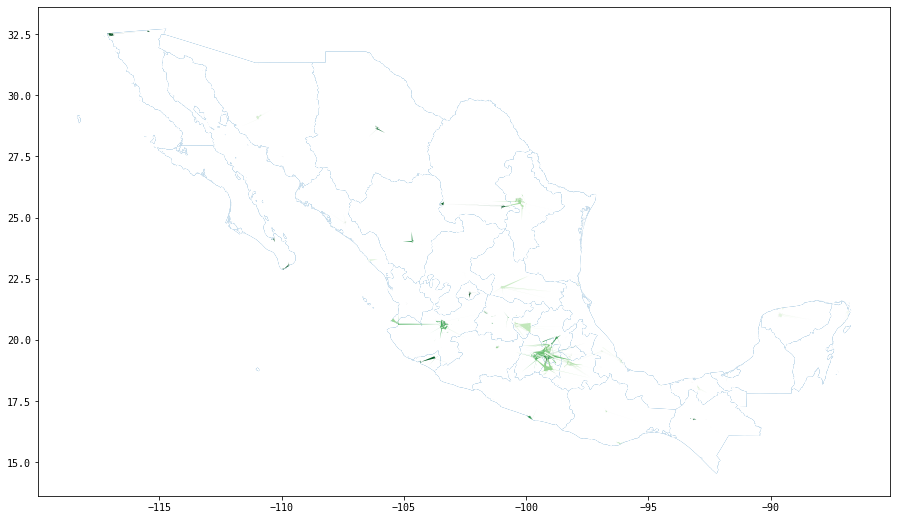

In [65]:
con_polygon = zonas_ok.loc[~zonas["polygon"].isna()]
geoDF = geopandas.GeoDataFrame(con_polygon, geometry="polygon")
base = pais.plot(figsize=(18,9))
estados_plot = estados.plot(ax=base, color="white")
plot = geoDF.plot(ax=estados_plot, cmap="Greens_r")

In [75]:
zonas_ok.loc[:,"centroid"] = zonas_ok.loc[~zonas_ok["polygon"].isna()]["polygon"].map(lambda x: x.centroid)

In [78]:
zonas_ok.sort_values(by="id_count", ascending=False)

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min,polygon,lat_dif,lng_dif,centroid
idzona,,,,,,,,,,,,,,,,,,,,,
84028.0,610.0,11009.720104,2582.311642,22413.793103,1903.278431,10880.046508,1975.915696,22413.793103,2929.687500,0.420654,...,3.0,0.0,2.423828,0.643555,4.0,1.0,"POLYGON ((-100.3527645060547 20.6460038109047,...",0.439569,0.648001,POINT (-99.98406126625852 20.54161490468353)
24823.0,575.0,19349.931317,8530.907233,60000.000000,2176.470588,17162.627796,9533.312801,200000.000000,2418.300654,7.921875,...,3.0,0.0,2.041016,0.800293,4.0,1.0,POLYGON ((-99.19589997523805 19.27962060115258...,0.371646,0.193023,POINT (-99.09073015406193 19.30740897549584)
339455.0,513.0,12921.119017,5081.532061,41089.108911,2876.543210,12027.004663,4231.243196,35047.619048,3030.303030,2.246094,...,3.0,0.0,2.412109,0.698242,4.0,1.0,"POLYGON ((-100.3482241 20.5986037, -100.343208...",0.115853,0.130680,POINT (-100.3932533256459 20.59900250636169)
343015.0,503.0,12290.126879,3941.583475,33333.333333,3500.000000,11698.947261,2778.120084,33333.333333,6209.935897,3.583984,...,3.0,0.0,2.375000,0.751465,4.0,1.0,"POLYGON ((-101.0400145 22.1500569, -101.028715...",0.516280,1.181095,POINT (-100.6992523319665 22.26613111263083)
47735.0,442.0,18846.159074,4613.109616,33108.108108,5510.460251,16350.122465,2760.791604,26870.748299,7242.990654,0.967773,...,3.0,0.0,3.214844,0.741699,4.0,1.0,POLYGON ((-103.4538077171875 20.71414000228824...,0.433882,1.816837,POINT (-97.34289328319723 22.06542613247069)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36441.0,1.0,7441.860465,NaN,7441.860465,7441.860465,5517.241379,NaN,5517.241379,5517.241379,7.000000,...,2.0,2.0,2.000000,NaN,2.0,2.0,NaN,0.000000,0.000000,NaN
91657.0,1.0,8737.864078,NaN,8737.864078,8737.864078,5471.124620,NaN,5471.124620,5471.124620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
36379.0,1.0,NaN,NaN,NaN,NaN,22166.666667,NaN,22166.666667,22166.666667,20.000000,...,3.0,3.0,3.000000,NaN,3.0,3.0,NaN,0.000000,0.000000,NaN


In [81]:
publicaciones_84028 = df.loc[df["idzona"]==84028.0] 
publicaciones_84028.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps
82,18684,oportunidad unica el refugio 3 rec con vestido...,hermosas y unicas residencias nuevas en el ref...,Casa en condominio,RESIDENCIAL DIAMANTE,Querétaro,Querétaro,0.0,3.0,2.0,...,True,True,True,1300000.0,8,2015,21,12037.037037,13265.306122,POINT (-100.3527645060547 20.6460038109047)


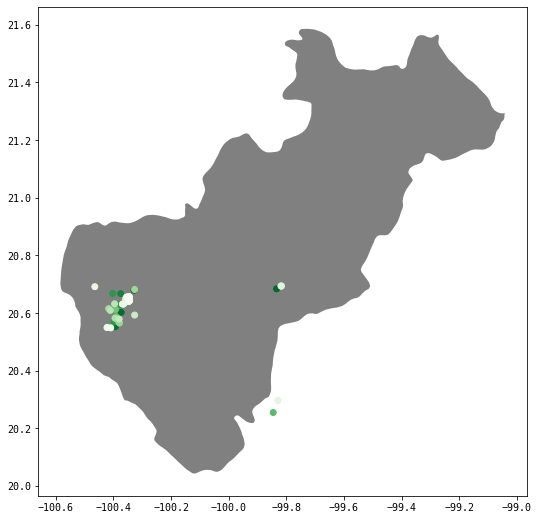

In [88]:
geoDF = geopandas.GeoDataFrame(publicaciones_84028, geometry="gps")
queretaro = estados.loc[estados["NAME_1"]=="Querétaro"].plot(figsize=(18,9),color="gray")
plot = geoDF.plot(ax=queretaro, cmap="Greens_r")

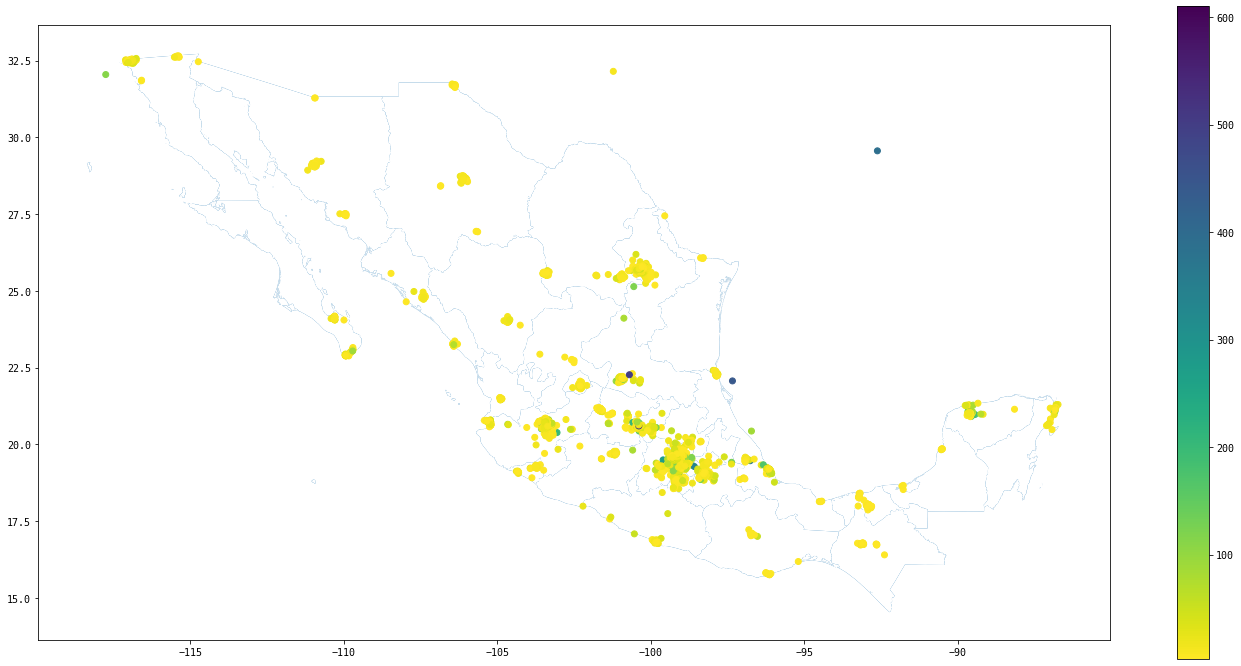

In [129]:
# quiero un mapa de mexico con todas las zonas (centroides), donde cada zona tenga un color que la diferencie de acuerdo a la cantidad de publicaciones que tiene
con_centroide = zonas_ok.loc[~zonas_ok["centroid"].isna()]
en_mexico = con_centroide.loc[con_centroide["centroid"].map(esta_en_mexico)]
geoDF = geopandas.GeoDataFrame(en_mexico, geometry="centroid")
base = pais.plot(figsize=(24,12))
estados_plot = estados.plot(ax=base, color="white")
plot = geoDF.plot(ax=estados_plot, cmap="viridis_r",legend=True, column="id_count")

In [109]:
en_mexico.loc[en_mexico["id_count"]>300]

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min,polygon,lat_dif,lng_dif,centroid
idzona,,,,,,,,,,,,,,,,,,,,,
23592.0,305.0,21819.633193,7797.250052,72566.666667,3191.489362,17225.084360,6067.070889,39080.459770,2000.000000,18.593750,...,3.0,0.0,2.296875,0.877930,4.0,1.0,"POLYGON ((-99.142520066667 19.342983066667, -9...",0.081555,0.067904,POINT (-99.15732129346141 19.35396628713254)
23598.0,356.0,22891.845299,8648.130644,55555.555556,5625.000000,20026.224273,6979.974112,43750.000000,5460.526316,12.953125,...,3.0,0.0,2.050781,0.907227,4.0,1.0,POLYGON ((-99.12154455128172 19.35064621324055...,0.086856,0.081391,POINT (-99.12001063941442 19.36971103533967)
23747.0,362.0,30773.718107,11430.845989,65757.627119,5000.000000,28808.443254,11532.927667,109375.000000,1680.000000,8.789062,...,3.0,0.0,2.777344,0.704102,4.0,1.0,POLYGON ((-99.25641439999998 19.38860750000001...,0.118800,0.080393,POINT (-99.08145871190531 19.15540753555931)
24823.0,575.0,19349.931317,8530.907233,60000.000000,2176.470588,17162.627796,9533.312801,200000.000000,2418.300654,7.921875,...,3.0,0.0,2.041016,0.800293,4.0,1.0,POLYGON ((-99.19589997523805 19.27962060115258...,0.371646,0.193023,POINT (-99.09073015406193 19.30740897549584)
25039.0,313.0,18797.376306,7084.265277,52083.333333,2135.135135,16821.928511,14940.454615,192000.000000,2135.135135,19.781250,...,3.0,0.0,1.648438,0.792969,4.0,1.0,"POLYGON ((-99.1059932463104 19.41315168827886,...",0.307454,0.126348,POINT (-99.15449161646119 19.37174443998289)
47732.0,402.0,20321.449550,6955.661865,43750.000000,4094.890511,21441.412566,6653.084619,71165.000000,5847.952632,2.728516,...,3.0,0.0,3.189453,0.844727,4.0,1.0,POLYGON ((-103.4319931908936 20.72960077873455...,0.111412,0.111597,POINT (-103.4260059173855 20.72721117057105)
47735.0,442.0,18846.159074,4613.109616,33108.108108,5510.460251,16350.122465,2760.791604,26870.748299,7242.990654,0.967773,...,3.0,0.0,3.214844,0.741699,4.0,1.0,POLYGON ((-103.4538077171875 20.71414000228824...,0.433882,1.816837,POINT (-97.34289328319723 22.06542613247069)
55574.0,345.0,21512.789054,7204.745475,47200.000000,1625.000000,22718.529923,26775.846180,447500.000000,10000.000000,14.554688,...,3.0,0.0,2.865234,0.711426,4.0,1.0,POLYGON ((-99.26449958203123 19.42319383647689...,0.338241,1.623854,POINT (-98.58274631809307 19.27605632499625)
55688.0,326.0,14519.104939,5143.914965,29671.794872,2875.000000,16791.231254,8257.199738,136842.105263,7000.000000,8.421875,...,3.0,0.0,3.095703,0.698242,4.0,1.0,"POLYGON ((-99.3179105 19.5721429, -99.30533129...",0.418986,0.360428,POINT (-99.17385001233357 19.43252163103534)


In [110]:
df.loc[df["idzona"]==113851.0]

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps
32,261416,"casa en venta en montebello, merida - pf","<p>planta baja:\n</p><p>sala, comedor, amplia ...",Casa,NaN,Mérida,Yucatán,NaN,3.0,2.0,...,False,False,False,3300000.0,4,2014,5,11301.369863,9295.774648,NaN
591,88364,"exclusiva casa en la mejor zona de merida, mon...",<p>aproveche precio de preventa!!\n</p><p>terr...,Casa,NaN,Mérida,Yucatán,NaN,3.0,2.0,...,False,False,False,3300000.0,4,2014,3,10312.500000,8333.333333,NaN
1475,31112,"casa en venta en montebello,mérida,yucatán.",<p>hermosa casa al norte de la ciudad con esqu...,Casa,NaN,Mérida,Yucatán,NaN,3.0,NaN,...,False,False,False,3195000.0,9,2014,11,10941.780822,9000.000000,NaN
2721,125780,oportunidad venta de casa minimalista en mont...,preciosa casa minimalista en montebello \nterr...,Casa,MONTEBELLO,Mérida,Yucatán,2.0,2.0,3.0,...,False,True,True,2100000.0,12,2016,25,10000.000000,7241.379310,NaN
4989,191144,hermosa residencia en montebello,<p>consta de:\n</p><p>\n</p><p>planta baja: sa...,Casa,NaN,Mérida,Yucatán,0.0,3.0,3.0,...,False,False,False,3500000.0,10,2013,8,11217.948718,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235732,272847,preciosa residencia a estrenar en montebello!!,<p>estrene preciosa residencia en el corazón d...,Casa,domicilio conocido,Mérida,Yucatán,1.0,3.0,2.0,...,True,True,False,2374370.0,10,2016,5,10234.353448,9311.254902,NaN
236080,114589,"casa clave en venta en montebello, merida , y...","casas de estilo minimalista, 2 plantas, al nor...",Casa,"Casa clave en Venta en Montebello, MERI",Mérida,Yucatán,0.0,NaN,0.0,...,False,False,False,2850000.0,10,2012,2,8382.352941,NaN,NaN
236309,223492,"casa en venta en montebello, mérida","preventa hermosa casa en montebello, 3 recamar...",Casa,Calle,Mérida,Yucatán,1.0,3.0,2.0,...,False,True,False,1850000.0,8,2012,27,10882.352941,9250.000000,NaN
236357,210124,casa residencial en fracc. montebello (en esqu...,"<p>a la venta preciosa casa en esquina, con ub...",Casa,NaN,Mérida,Yucatán,NaN,3.0,3.0,...,False,False,False,2990000.0,3,2014,12,8305.555556,NaN,NaN
